In [4]:
import pandas as pd
import numpy as np
import scanpy as sc

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import rc
from sklearn.ensemble import GradientBoostingClassifier

rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{cmbright}')
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})

%matplotlib inline

# This enables SVG graphics inline. 
%config InlineBackend.figure_formats = {'png', 'retina'}

rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style("dark")

mpl.rcParams['xtick.labelsize'] = 16 
mpl.rcParams['ytick.labelsize'] = 16 
mpl.rcParams['legend.fontsize'] = 14

ensembl = sc.queries.biomart_annotations(org='hsapiens',
                                         attrs=['ensembl_gene_id', 'gene_biotype',
                                                'external_gene_name', 'description'])

In [5]:
df = pd.read_csv('../luminalAB/mrna/trimmedTMM.csv', index_col='geneid')
logdf = pd.read_csv('../luminalAB/mrna/logTMM.csv', index_col='geneid')
normed = pd.read_csv('../luminalAB/mrna/NormalizedlogTMM.csv', index_col='geneid')
meta = pd.read_csv('../luminalAB/mrna/lumAB_id_cancer.txt', sep='\t')
meta.ID = meta.ID.astype('category')
meta.ID.cat.set_categories(df.columns, inplace=True)
meta.sort_values("ID", inplace=True)
ensembl = ensembl[ensembl.ensembl_gene_id.isin(df.index)]

In [8]:
train_idx = np.random.choice(normed.T.index.values, size=np.int(np.floor(len(normed.columns) / 3 * 2))).tolist()
test_idx = [n for n in normed.T.index if n not in train_idx]

train_exp = normed.T[normed.T.index.isin(train_idx)]
train_labels = meta[meta.ID.isin(train_idx)].cancer 

test_exp = normed.T[normed.T.index.isin(test_idx)]
test_labels = meta[meta.ID.isin(test_idx)].cancer 

In [101]:
clf = GradientBoostingClassifier(n_estimators=200, learning_rate=.05, subsample=0.75,
                                 max_depth=5, random_state=1, max_features='sqrt').fit(train_exp, train_labels)

In [102]:
clf.score(test_exp, test_labels)

0.8588957055214724

200


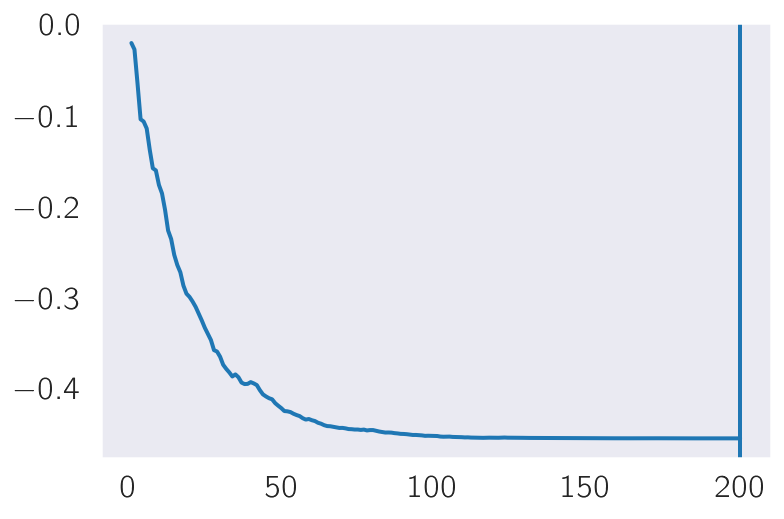

In [103]:
x = np.arange(200) + 1

# negative cumulative sum of oob improvements
cumsum = -np.cumsum(clf.oob_improvement_)
oob_best_iter = x[np.argmin(cumsum)]

# min loss according to OOB
oob_best_iter = x[np.argmin(cumsum)]
plt.plot(x, cumsum, label='OOB loss')
plt.axvline(x=oob_best_iter)
print(oob_best_iter)

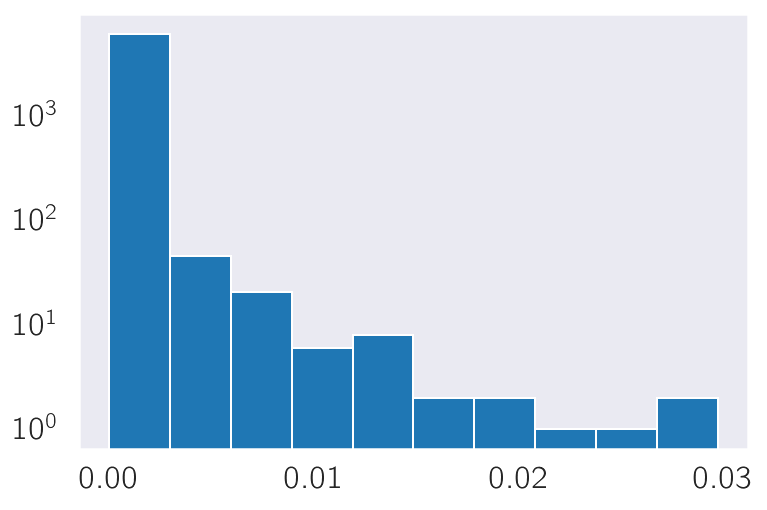

In [104]:
plt.hist(clf.feature_importances_)
plt.yscale('log')

In [112]:
def get_features(data, cond=(clf.feature_importances_ > 0.005)):
    markers = data.index[cond].values
    ens_mark = ensembl[ensembl.ensembl_gene_id.isin(markers)].copy()
    ens_mark.ensembl_gene_id = ens_mark.ensembl_gene_id.astype('category')
    ens_mark.ensembl_gene_id.cat.set_categories(markers, inplace=True)
    ens_mark.sort_values("ensembl_gene_id", inplace=True)
    missing = np.array([0 if m not in ensembl.ensembl_gene_id.values else 1 for m in markers ])
    return ens_mark, missing

get_features(data)

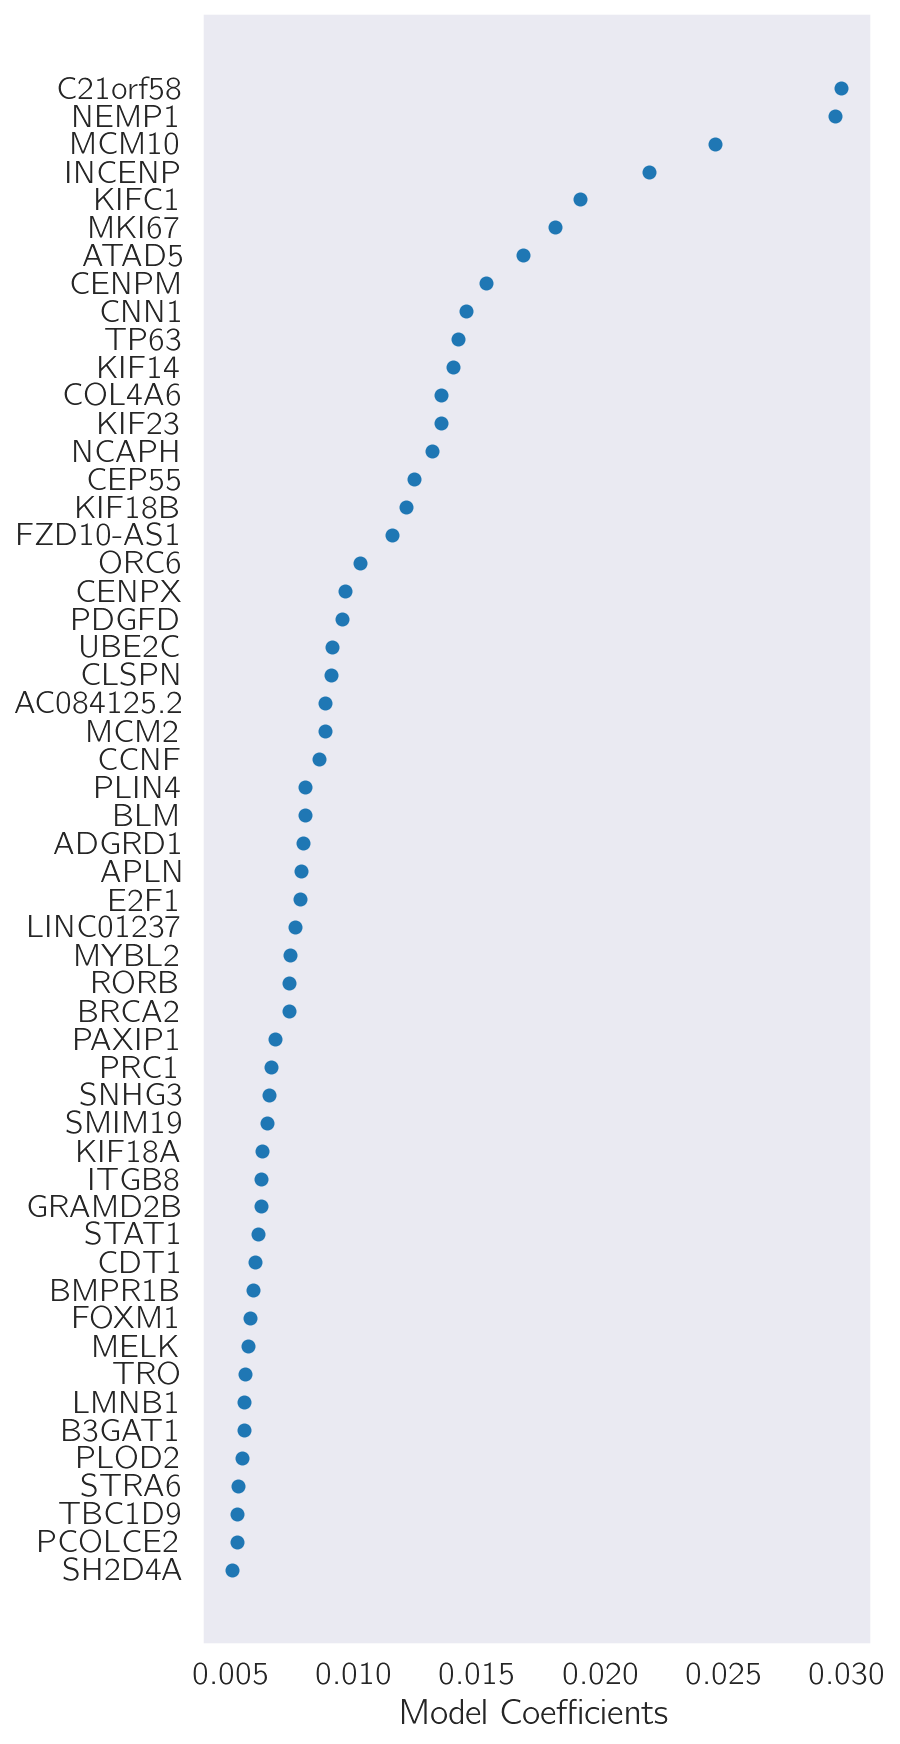

In [106]:
x = clf.feature_importances_[clf.feature_importances_ > 0.005][missing != 0]
sort = np.argsort(x)

fig, ax = plt.subplots(figsize=(6, 15))

plt.plot(x[sort], ens_mark.external_gene_name.values[sort],
         'o')
_ = plt.xlabel('Model Coefficients')

In [107]:
sc.queries.enrich(ens_mark.ensembl_gene_id)

,source,native,name,p_value,significant,description,term_size,query_size,intersection_size,effective_domain_size,precision,recall,query,parents
0,GO:BP,GO:1903047,mitotic cell cycle process,4.034822e-16,True,"""A process that is part of the mitotic cell cy...",921,46,24,18092,0.521739,0.026059,query_1,"[GO:0000278, GO:0022402]"
1,GO:BP,GO:0022402,cell cycle process,3.877827e-15,True,"""The cellular process that ensures successive ...",1447,46,27,18092,0.586957,0.018659,query_1,"[GO:0007049, GO:0009987]"
2,GO:BP,GO:0000278,mitotic cell cycle,1.253891e-14,True,"""Progression through the phases of the mitotic...",1069,46,24,18092,0.521739,0.022451,query_1,[GO:0007049]
3,GO:BP,GO:0007049,cell cycle,4.668717e-12,True,"""The progression of biochemical and morphologi...",1914,46,27,18092,0.586957,0.014107,query_1,[GO:0009987]
4,REAC,REAC:R-HSA-1640170,Cell Cycle,6.279406e-11,True,Cell Cycle,624,36,18,10531,0.500000,0.028846,query_1,[REAC:0000000]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,GO:BP,GO:0000226,microtubule cytoskeleton organization,4.557297e-02,True,"""A process that is carried out at the cellular...",617,46,9,18092,0.195652,0.014587,query_1,"[GO:0007010, GO:0007017]"
99,GO:CC,GO:0099081,supramolecular polymer,4.637214e-02,True,"""A polymeric supramolecular structure."" [GOC:dos]",1014,48,10,18963,0.208333,0.009862,query_1,[GO:0099080]
100,GO:BP,GO:0044786,cell cycle DNA replication,4.805480e-02,True,"""The DNA-dependent DNA replication that takes ...",65,46,4,18092,0.086957,0.061538,query_1,"[GO:0006261, GO:0022402]"
101,GO:CC,GO:0000779,"condensed chromosome, centromeric region",4.889873e-02,True,"""The region of a condensed chromosome that inc...",114,48,4,18963,0.083333,0.035088,query_1,"[GO:0000775, GO:0000793]"


In [108]:
# test feature stability:
reps = []

for i in np.arange(1, 50):
    clf = GradientBoostingClassifier(n_estimators=200, learning_rate=.05, subsample=0.75,
                                 max_depth=5, random_state=i, max_features='sqrt').fit(train_exp, train_labels)
    reps += [clf]

In [115]:
# extract features:
genes = []
for r in reps:
    f, miss = get_features(normed, r.feature_importances_ > 0.005)
    f = f.external_gene_name.values
    genes += f.tolist()

In [121]:
uniq, counts = np.unique(genes, return_counts=True)
print(len(uniq), counts.min(), counts.max())

994 1 23


(array([835.,  61.,  30.,  20.,  18.,  17.,   5.,   3.,   2.,   3.]),
 array([ 1. ,  3.2,  5.4,  7.6,  9.8, 12. , 14.2, 16.4, 18.6, 20.8, 23. ]),
 <BarContainer object of 10 artists>)

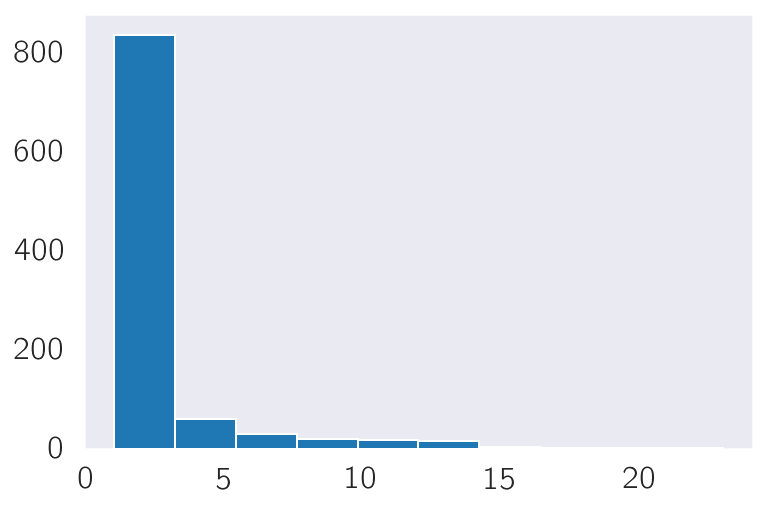

In [123]:
plt.hist(counts)

Text(0.5, 1.0, 'Features present in $>10$ ensemble runs')

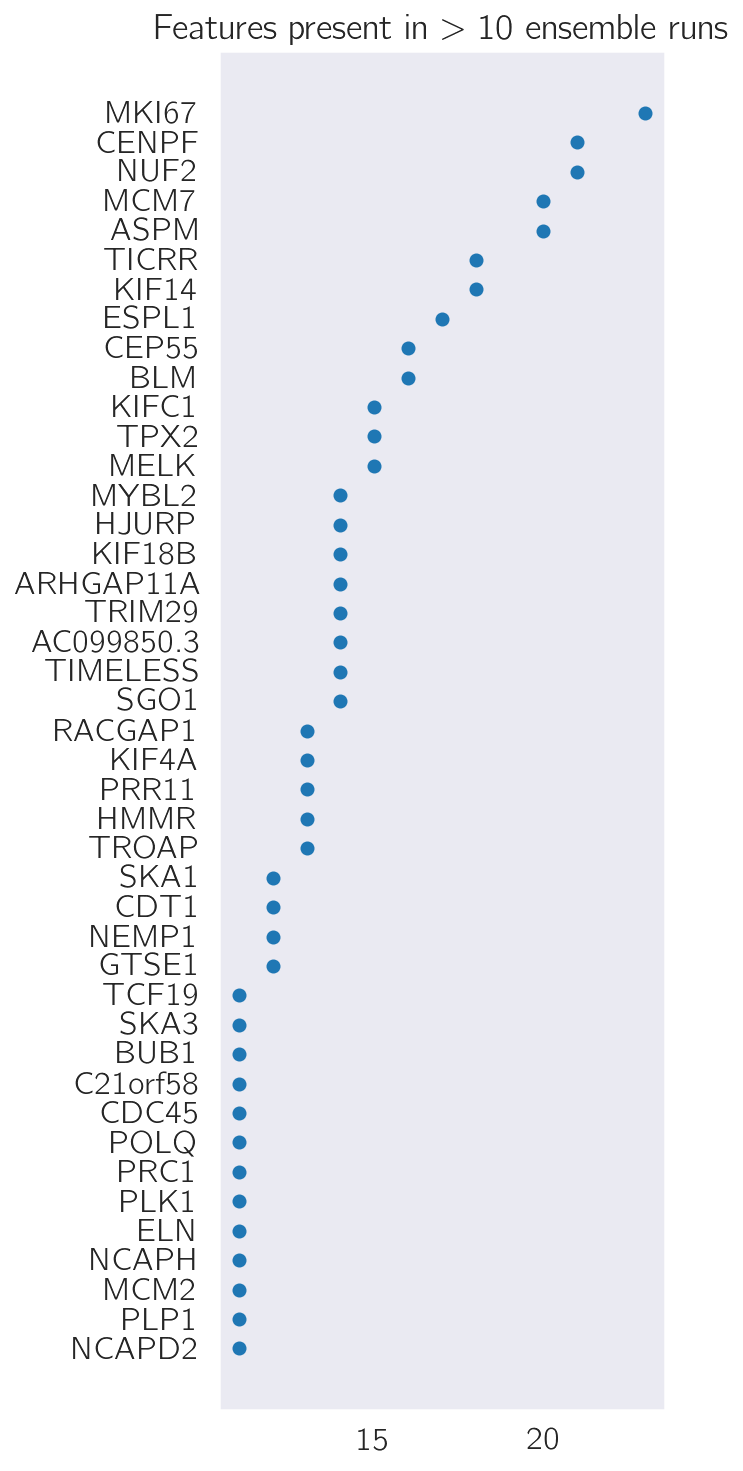

In [184]:
fig, ax = plt.subplots(figsize=(4, 12.5))
x = counts[counts > 10]
y = uniq[counts > 10]
idx = np.argsort(x)
plt.scatter(x[idx], y[idx])
plt.title('Features present in $>10$ ensemble runs')

(array([ 2.,  4.,  7.,  9.,  0., 11.,  4.,  8.,  3.,  1.]),
 array([0.83435583, 0.8392638 , 0.84417178, 0.84907975, 0.85398773,
        0.85889571, 0.86380368, 0.86871166, 0.87361963, 0.87852761,
        0.88343558]),
 <BarContainer object of 10 artists>)

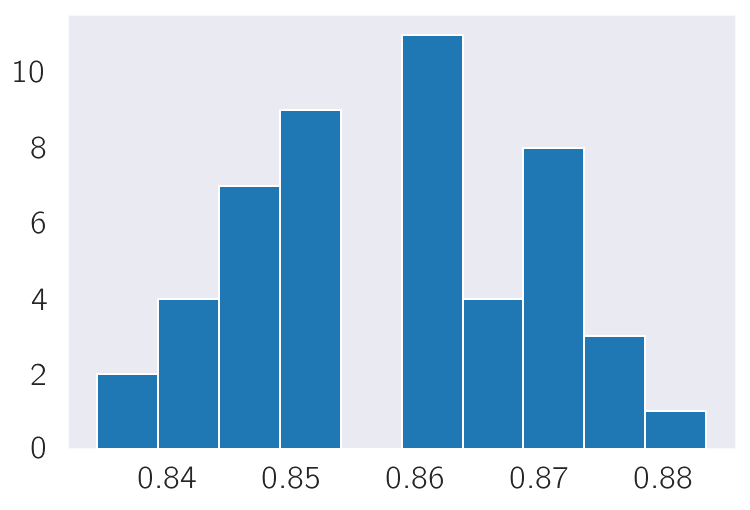

In [128]:
plt.hist([r.score(test_exp, test_labels) for r in reps])

In [140]:
results = sc.queries.enrich(uniq[counts > 3])

In [177]:
def collapse(x):
    x = x.lower()
    if 'regulation of dna' in x:
        return 'dna-regulation'
    if ('mitot' in x) | ('metaphase' in x) | ('anaphase' in x) | ('cell division' in x) | ('centromere' in x):
        return 'mitosis'
    if 'meiosi' in x:
        return 'meiosis'
    if ('chromosome' in x) | ('chromosomal' in x):
        return 'chromosome'
    if ('cell cycle' in x) | ('g0' in x) | ('g1' in x) | ('g2' in x) | ('s phase' in x):
        return 'cell cycle'
    if 'cytokin' in x:
        return 'cytokinesis'
    if ('condensin' in x) | ('centrosome' in x) | ('kinetochore' in x) | ('microtubule' in x) | ('spindle' in x) | ('sister' in x):
        return 'chrom condensation'
    if 'nuclear' in x:
        return 'nuclear'
    if 'testis' in x:
        return 'testis'
    if 'supramolecular' in x:
        return 'supramolecular'
    if 'e2f; motif' in x:
        return 'e2f motif'
    if 'e2f-1' in x:
        return 'e2f-1 motif'
    if 'nf-ya; motif' in x:
        return 'nf-ya motif'
    if 'factor' in x:
        return 'factor motif, varied'
    if ('dna' in x) | ('double-strand' in x):
        return 'dna damage, integrity, packaging, repair or replication'
    if ('abnormal' in x) | ('deviation' in x) | ('head' in x) | ('forehead' in x) | ('clinodactyly' in x):
        return 'morphological abnormality, varied'
    if ('breast' in x):
        return "BREAST-" + x
    if ('cancer' in x):
        return 'cancer'
    if ('mhc class ii' in x):
        return 'mch class ii'
    
    else:
        return x
    
trimmed, trim_counts = np.unique([collapse(name) for name in results.name], return_counts=True)

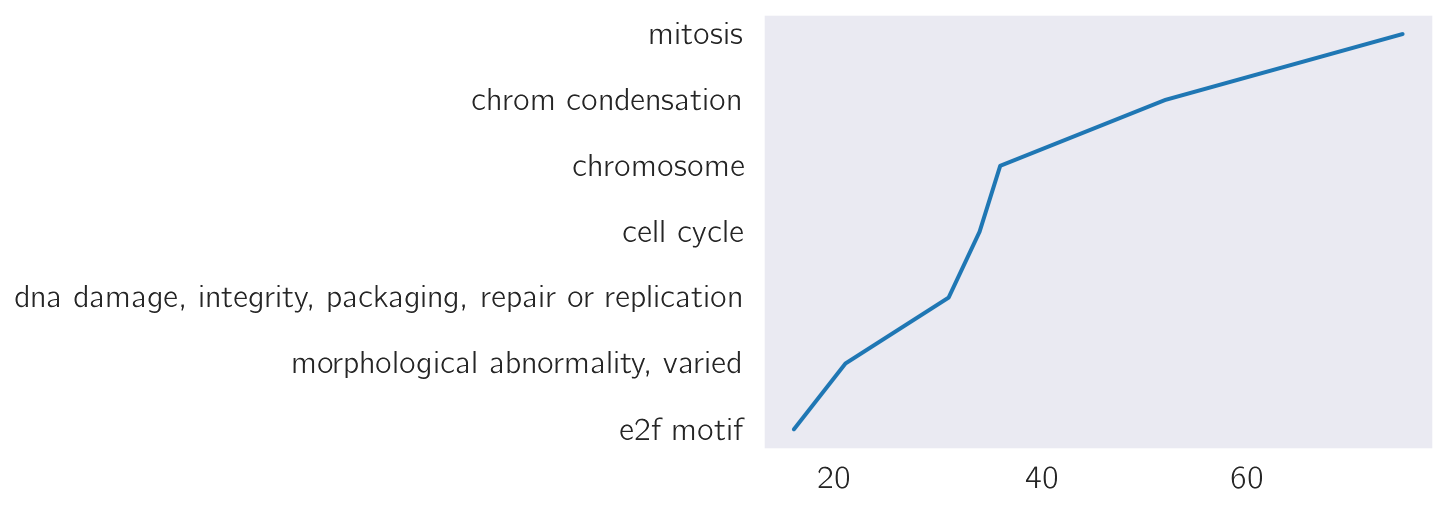

In [180]:
x = trim_counts[trim_counts > 15]
y = trimmed[trim_counts > 15]
idx = np.argsort(x)
if len(x) < 50:
    plt.plot(x[idx], y[idx])
else:
    print('too many')